In [1]:
using Revise
using Pkg
Pkg.develop(path="/home/stephenz/stephenz/locaTE.jl")

[ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
   Resolving package versions...
    Updating `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/pancreas/Project.toml`
  [d47a2e43] ~ locaTE v0.3.1 `/data/gpfs/projects/punim0638/stephenz/locaTE.jl#main` ⇒ v0.3.5 `~/stephenz/locaTE.jl`
    Updating `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/pancreas/Manifest.toml`
  [d47a2e43] ~ locaTE v0.3.1 `/data/gpfs/projects/punim0638/stephenz/locaTE.jl#main` ⇒ v0.3.5 `~/stephenz/locaTE.jl`


In [2]:
using NPZ
using locaTE
using NearestNeighbors
using Graphs
using GraphSignals
using SparseArrays
using LinearAlgebra
using Plots
using StatsBase
using CUDA
using Random
using NNlib

[ Info: Precompiling locaTE [d47a2e43-82e6-47ba-a340-eddb77145d33]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/backends.jl:43


In [3]:
DATA_DIR = "../../data/pancreas/"
X = npzread(string(DATA_DIR, "X.npy"))
TE = npzread("TE_locate.npy");
L = sparse(npzread("L_locate.npy"));
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0;

In [4]:
Random.seed!(0)
U, V, trace = fitnmf(cu(relu.(qnorm(TE, 0.9))),
                     [I(size(TE, 1)), I(size(TE, 2))], 1e-3*I + L,
                     cu(repeat(vec(Cg), 1, size(X, 1))'),
                     16; 
                     α = 10.0,
                     β = 0.0, 
              λ = [1, 1],
              μ = [1, 1],
              iter = 10_000, initialize = :nmf, print_iter = 50, dictionary = false, η = 1.0);
G_nmf = Array(U*V');
U = Array(U); V = Array(V);
# rescale U, V
# U .*= mean(V; dims = 1)
# V ./= mean(V; dims = 1);
# npzwrite("U.npy", U)
# npzwrite("V.npy", V)

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:06:13:50


In [5]:
V .*= maximum(U; dims = 1)
U ./= maximum(U; dims = 1);
# 
A = reshape(maximum(V'; dims = 1), size(X, 2), size(X, 2))
for i = 1:size(V, 2)
    x = reshape(V[:, i], size(X, 2), size(X, 2))
    V[:, i] .= vec(cdf_norm(x, A .+ 1e-9))
end
npzwrite("U.npy", U)
npzwrite("V.npy", V)

In [ ]:
plot(trace)

In [7]:
# NTF
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
S, A, trace = fitntf(cu(reshape(qnorm(TE, 0.9), :, size(X, 2), size(X, 2))),
                     [Array{Float32}(I(size(X, 1))), Array{Float32}(I(size(X, 2))), Array{Float32}(I(size(X, 2)))], Array{Float32}(1e-3*I + L), 
                     cu(repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1))), 
                     [1, 1, 1],
                     [1, 1, 1],
                     10.0,
                     0.0,
                     36; iter = 500, dictionary = false, η = 1.0);

┌ Warning: Performing scalar indexing on task Task (runnable) @0x000015479c2926e0.
│ Invocation of setindex! resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/B3xv7/src/GPUArraysCore.jl:103


LoadError: MethodError: no method matching ttm(::CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}, ::Vector{CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, ::Vector{Int64})
[0mClosest candidates are:
[0m  ttm(::AbstractArray{<:Number}, [91m::Array{Matrix{T}, 1}[39m, ::Vector{<:Integer}) where T<:Number at ~/.julia/packages/TensorToolbox/6LauI/src/tensor.jl:648
[0m  ttm(::AbstractArray{<:Number}, [91m::Array{Matrix{T}, 1}[39m, ::Vector{<:Integer}, [91m::Any[39m) where T<:Number at ~/.julia/packages/TensorToolbox/6LauI/src/tensor.jl:648
[0m  ttm(::AbstractArray{<:Number, N}, [91m::Vector{AbstractMatrix{<:Number}}[39m, ::AbstractVector{<:Integer}) where N at ~/.julia/packages/TensorToolbox/6LauI/src/tensor.jl:607
[0m  ...

In [8]:
for i = 1:length(A)
    npzwrite("A_$i.npy", Array(A[i]))
end

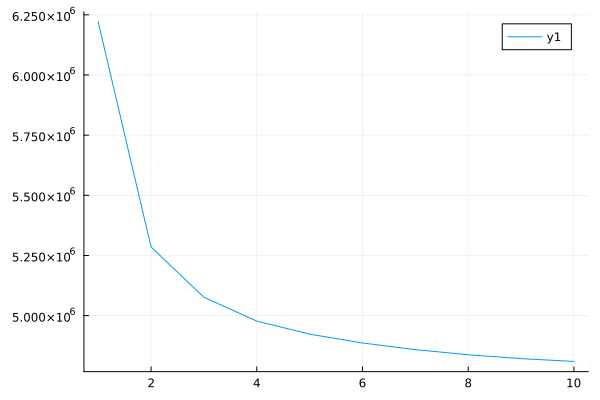

In [9]:
plot(trace)